# Extract ATL15 delta_h from either local storage or direct from NSIDC S3 storage

This notebook reads ATL15 from either local disk or direct from NSIDC S3 storage. Reading direct from S3 will work only if this notebook is run on a cloud computing system that is running in the AWS us-west-2 region.

### Configuring Earthdata Authentication

You will need to setup Earthdata authentication to successfully use the NSIDC S3 bucket. A set of functions are included below to facilitate this (compiled from multiple sources, listed below). You can automate authentication by creating a ".netrc" file in your home directory and writing the following:

```
machine urs.earthdata.nasa.gov
    login <earthdata username>
    password <earthdata password>
```

On the SMCE JupyterHub, it is recommended that you do this from a terminal. First make sure you are in your home directory (`cd ~`), then create a new file and include the following:

```
cat >> .netrc
machine urs.earthdata.nasa.gov
    login <username>
    password <password>

```

Press `Enter` and then type `Ctrl+C` to save and close the prompt.

> **⚠️ Warning:** After writing the file, we _**strongly**_ recommend setting the new `.netrc` file to read-only for only the user using `chmod 0400 .netrc`. If you later need to edit this file, you can temporarily allow read/write by only the user with `chmod 0600 .netrc`. **NOTE:** Some SMCE users have found that they must reset the 0400 permissions every time they start a new SMCE server. If you find this to be the case, you can simply add the correct command to your bash profile or else run the first cell in this notebook. Alternatively, you may wish to forego using a .netrc file altogether and instead use the login prompt below to authenticate each time you use this notebook. _However, that prompt appears to be broken at this time..._

If configured successfully, you should see the following output from the second notebook cell.

```
# Your URS credentials were securely retrieved from your .netrc file.
Earthdata login credentials configured. Ready.
```

Otherwise, you will see a message saying it could not use the .netrc file and it will ask you to input your username and password.

```
There's no .netrc file or the The endpoint isn't in the netrc file. Please provide...
# Your info will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter.
Username: 
```

---

*Note: There is a pip package called "earthdata" that is supposed to help with this process, primarily in reducing code that we must write. However, I (Mike Croteau) have not been able to get it to install on the SMCE. I've tried cloning the default environment and installing this extra package with conda, as suggested by the earthdata devs, but I get unresolvable package inconsistencies. If anyone can get this working, please share.*

---

Sources:

- [Use Case: Study Amazon Estuaries with Data from the EOSDIS Cloud](https://github.com/podaac/tutorials/blob/master/notebooks/SWOT-EA-2021/Estuary_explore_inCloud_zarr.ipynb)
- [SWOT Oceanography with PO.DAAC](https://git.mysmce.com/eis-sealevel/swot/-/blob/main/tutorials/.ipynb_checkpoints/SWOT_simulated_L2_SSH_introduction-checkpoint.ipynb)
- ["Update cloud_direct_access_s3.py" - podaac tutorials commit 4da70c7cf079ddd7a6de4c4345749f580ba66d71](https://github.com/podaac/tutorials/commit/4da70c7cf079ddd7a6de4c4345749f580ba66d71#)

In [1]:
!chmod 0400 ~/.netrc

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import progressbar
import s3fs
from scipy.io import loadmat

In [3]:
from urllib import request
from http.cookiejar import CookieJar
import netrc
import requests
import s3fs
import getpass

def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them.
    Valid endpoints:
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
        print('# Your URS credentials were securely retrieved from your .netrc file.')
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print("There's no .netrc file or the The endpoint isn't in the netrc file. Please provide...")
        print('# Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass.getpass('Password: ')

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    
def begin_s3_direct_access():
    url="https://data.nsidc.earthdatacloud.nasa.gov/s3credentials"
    r = requests.get(url)
    response = r.json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],secret=response['secretAccessKey'],token=response['sessionToken'],client_kwargs={'region_name':'us-west-2'})

edl = "urs.earthdata.nasa.gov"
setup_earthdata_login_auth(edl)
print('Earthdata login credentials configured. Ready.')

# Your URS credentials were securely retrieved from your .netrc file.
Earthdata login credentials configured. Ready.


### Define a function for plotting ATL15 data

In [8]:
def plot_atl15(ds_atl15, xs, ys):
    x_ATL15 = ds_atl15.x.values
    y_ATL15 = ds_atl15.y.values
    
    fig, ax = plt.subplots(1,3,figsize=(10,5))

    idx = 5
    
    # Plot all of Greenland
    im0 = ax[0].imshow(ds.delta_h[idx,:,:] - ds.delta_h[0,:,:], vmin=-3, vmax=+3, cmap='RdBu', origin='lower', interpolation='nearest')

    # Plot region containing x/y locations and the time series from those locations
    im1 = ax[1].imshow(ds.delta_h[idx,:,:] - ds.delta_h[0,:,:], vmin=-3, vmax=+3, cmap='RdBu', interpolation='nearest')

    year0  = ds.time[0].values.astype('datetime64[Y]').astype(int) + 1970
    month0 = ds.time[0].values.astype('datetime64[M]').astype(int) % 12 + 1
    year  = ds.time[idx].values.astype('datetime64[Y]').astype(int) + 1970
    month = ds.time[idx].values.astype('datetime64[M]').astype(int) % 12 + 1
    
    ax[1].set_title('{:02d}/{:4d} - {:02d}/{:4d}'.format(month0, year0, month, year))
    
    for x, y in zip(xs, ys):
        col = np.argmin(np.abs(x_ATL15-x))
        row = np.argmin(np.abs(y_ATL15-y))

        delta_h_ATL15 = ds.delta_h[:,row,col] - ds.delta_h[0,row,col]
        ax[1].plot(col, row, 'o')
        ax[2].plot(delta_h_ATL15)

    cbar = plt.colorbar(im0, ax=ax[0], orientation='horizontal', shrink=0.75)
    cbar.ax.set_xlabel('delta_h (m)')
    cbar = plt.colorbar(im1, ax=ax[1], orientation='horizontal', shrink=0.75)
    cbar.ax.set_xlabel('delta_h (m)')
    ax[1].set_xlim([col-30, col+30])
    ax[1].set_ylim([row-30, row+50])
    ax[2].set_xlabel('ATL15 quarter')
    ax[2].set_ylabel('delta_h (m)')

    return fig, ax


In [9]:
# Example coordinates
xs = list(); ys = list();
x, y = -198210, -2178125; xs.append(x); ys.append(y);
x, y = -203568, -2188116; xs.append(x); ys.append(y);
x, y = -200702, -2171673; xs.append(x); ys.append(y);
x, y = -200195, -2200813; xs.append(x); ys.append(y);


## Read local ATL15 files

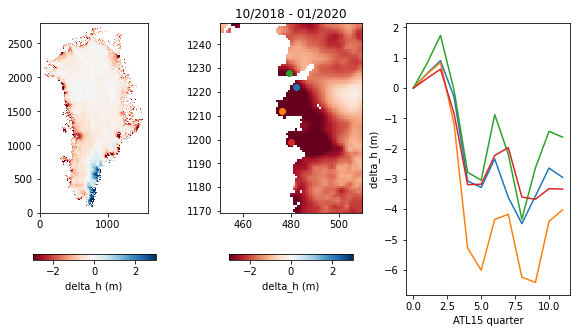

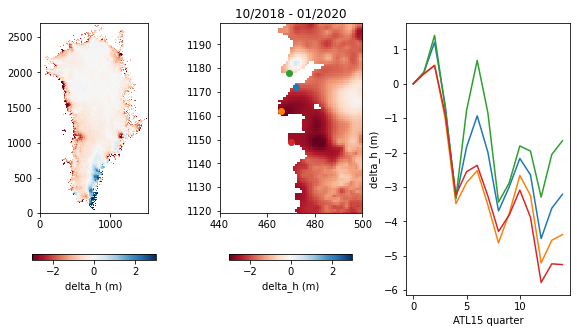

In [10]:
ncfilenames = ['/efs/dfelikso/ATL15_GL_0311_01km_001_01.nc', '/efs/dfelikso/ATL15_GL_0314_01km_002_01.nc']

for ncfilename in ncfilenames:
    ds = xr.open_dataset(ncfilename, group='delta_h')
    
    plot_atl15(ds, xs, ys)
    
    ds.close()


## Read direct from S3

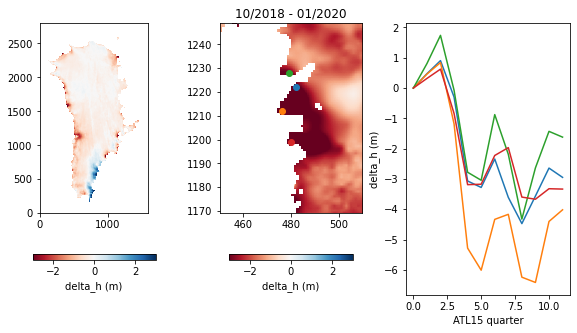

In [7]:
fs = begin_s3_direct_access()

s3_bucket = 's3://nsidc-cumulus-prod-protected/ATLAS/ATL15/001/2019/ATL15_GL_0311_01km_001_01.nc'
s3_files = fs.glob(s3_bucket)

file = fs.open(s3_files[0])
ds = xr.open_dataset(file, group='delta_h')

plot_atl15(ds, xs, ys)

ds.close()
